## پرسپترون‌های چندلایه
## ساخت چارچوب عصبی خود

> این نوت‌بوک بخشی از [برنامه درسی هوش مصنوعی برای مبتدیان](http://github.com/microsoft/ai-for-beginners) می‌باشد. جهت دسترسی به مجموعه کامل مواد آموزشی به مخزن مذکور مراجعه فرمایید.

در این نوت‌بوک، به تدریج چارچوب عصبی خود را که قادر به حل وظایف طبقه‌بندی چندکلاسه و همچنین رگرسیون با استفاده از پرسپترون‌های چندلایه می‌باشد، خواهیم ساخت.

ابتدا، بیایید برخی از کتابخانه‌های مورد نیاز را وارد کنیم.

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random

## مجموعه داده‌ی نمونه

همان‌طور که پیش‌تر اشاره شد، ما با یک مجموعه داده‌ی نمونه‌ی ساده که شامل دو پارامتر است، آغاز خواهیم کرد.


In [2]:
n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Split into train and test dataset
train_x, test_x = np.split(X, [n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])

In [3]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

<IPython.core.display.Javascript object>


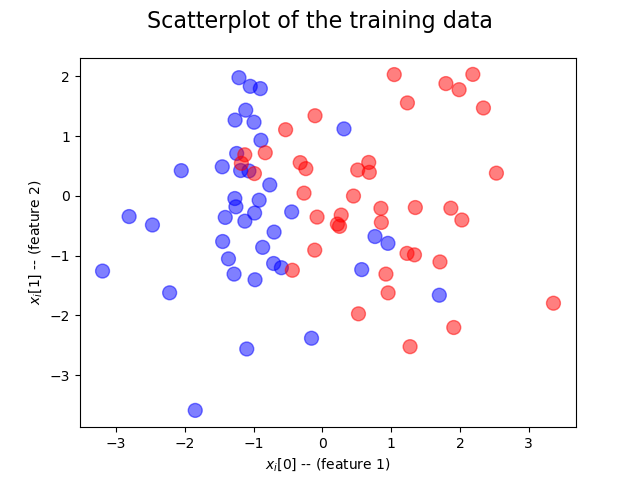

In [4]:
plot_dataset('Scatterplot of the training data', train_x, train_labels)
plt.show()

In [5]:
print(train_x[:5])
print(train_labels[:5])

[[ 1.3382818  -0.98613256]
 [ 0.5128146   0.43299454]
 [-0.4473693  -0.2680512 ]
 [-0.9865851  -0.28692   ]
 [-1.0693829   0.41718036]]
[1 1 0 0 0]


## مساله یادگیری ماشین

فرض کنید که ما یک مجموعه ورودی $\langle X, Y \rangle$ داریم، که در آن $X$ مجموعه‌ای از ویژگی‌ها و $Y$ برچسب‌های متناظر است. در مسئله رگرسیون، مقدار $y_i \in \mathbb{R}$ و در مورد طبقه‌بندی، با شماره کلاس $y_i \in \{0, \dots, n\}$ نمایش داده می‌شود.

هر مدل یادگیری ماشین می‌تواند به‌صورت تابع $f_{\theta}(x)$ بیان گردد، که در آن $ \theta$ مجموعه‌ای از **پارامترها** است. هدف ما، یافتن پارامترهایی است که مدل ما به بهترین نحو با مجموعه داده‌ها هماهنگ باشد. معیاری که این هماهنگی را تعریف می‌کند، **تابع هزینه** $\mathcal{L}$ نامیده می‌شود و ما باید مقدار بهینه آن را بیابیم:

$$
\theta = \mathrm{argmin}_{\theta} \mathcal{L}(f_{\theta}(X), Y)
$$

تابع زیان به مسأله‌ای که در حال حل آن هستیم وابسته است.

### توابع زیان برای رگرسیون

برای رگرسیون، معمولاً از **خطای مطلق** $\mathcal{L}_{abs}(\theta) = \sum_{i=1}^n |y_i - f_{\theta}(x_i)|$ یا **توان دوم خطا**: $\mathcal{L}_{sq}(\theta) = \sum_{i=1}^n (y_i - f_{\theta}(x_i))^2$ استفاده می‌شود.

In [7]:
# helper function for plotting various loss functions
def plot_loss_functions(suptitle, functions, ylabels, xlabel):
    fig, ax = plt.subplots(1,len(functions), figsize=(9, 3))
    plt.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle)
    for i, fun in enumerate(functions):
        ax[i].set_xlabel(xlabel)
        if len(ylabels) > i:
            ax[i].set_ylabel(ylabels[i])
        ax[i].plot(x, fun)
    plt.show()

<IPython.core.display.Javascript object>


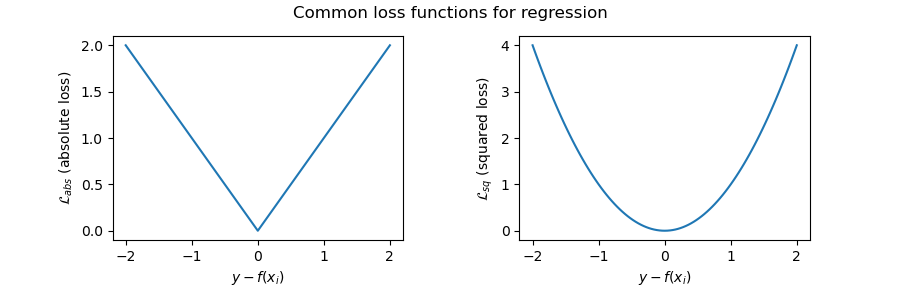

In [8]:
x = np.linspace(-2, 2, 101)
plot_loss_functions(
    suptitle = 'Common loss functions for regression',
    functions = [np.abs(x), np.power(x, 2)],
    ylabels   = ['$\mathcal{L}_{abs}}$ (absolute loss)',
                 '$\mathcal{L}_{sq}$ (squared loss)'],
    xlabel    = '$y - f(x_i)$')

### تابع‌های زیان برای طبقه‌بندی

بیایید به بررسی طبقه‌بندی دوتایی بپردازیم. در اینجا، ما دو کلاس داریم که به ترتیب با شماره‌های ۰ و ۱ مشخص شده‌اند. خروجی شبکه $f_\theta(x_i)\in [0,1]$ به طور بنیادی احتمال انتخاب کلاس ۱ را تعریف می‌کند.

**زیان ۰-۱**

زیان ۰-۱ مشابه محاسبه دقت مدل است؛ به این معنا که ما تعداد طبقه‌بندی‌های صحیح را محاسبه می‌کنیم:

$$\mathcal{L}_{0-1} = \sum_{i=1}^n l_i \quad  l_i = \begin{cases}
         0 & (f(x_i)<0.5 \land y_i=0) \lor (f(x_i)<0.5 \land y_i=1) \\
         1 & \mathrm{ otherwise}
       \end{cases} \\
$$

با این حال، دقت خود به تنهایی نمی‌تواند نشان دهد که چقدر از طبقه‌بندی صحیح فاصله داریم. ممکن است که ما فقط به‌طور جزئی کلاس صحیح را از دست داده باشیم که از یک منظر "بهتر" به‌حساب می‌آید (از این لحاظ که نیاز به اصلاح وزن‌ها به مراتب کمتر خواهد بود) تا این که به‌طور قابل توجهی آن را از دست بدهیم. بنابراین، به‌طور متداول از زیان لگاریتمی استفاده می‌شود که به این موضوع توجه می‌کند.

**زیان لگاریتمی**

$$\mathcal{L}_{log} = \sum_{i=1}^n -y\log(f_{\theta}(x_i)) - (1-y)\log(1-f_\theta(x_i))$$


In [9]:
x = np.linspace(0,1,100)
def zero_one(d):
    if d < 0.5:
        return 0
    return 1
zero_one_v = np.vectorize(zero_one)

def logistic_loss(fx):
    # assumes y == 1
    return -np.log(fx)

/tmp/ipykernel_31304/331859503.py:10: RuntimeWarning: divide by zero encountered in log
  return -np.log(fx)


<IPython.core.display.Javascript object>


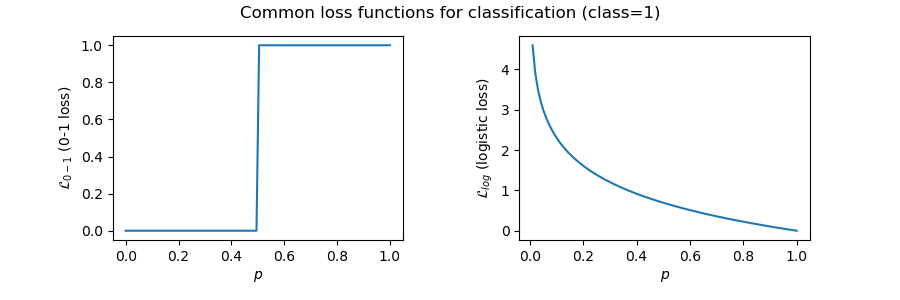

In [10]:
plot_loss_functions(suptitle = 'Common loss functions for classification (class=1)',
                   functions = [zero_one_v(x), logistic_loss(x)],
                   ylabels    = ['$\mathcal{L}_{0-1}}$ (0-1 loss)',
                                 '$\mathcal{L}_{log}$ (logistic loss)'],
                   xlabel     = '$p$')


برای درک ضرر لگاریتمی، دو حالت از خروجی مورد انتظار را مورد بررسی قرار می‌دهیم:

* اگر انتظار داشته باشیم که خروجی برابر با 1 باشد ($y=1$)، در این صورت ضرر برابر با $-log f_\theta(x_i)$ تعیین می‌شود. ضرر برابر با صفر خواهد بود اگر شبکه با احتمال یک، پیش‌بینی کند که خروجی 1 است، و با کاهش احتمال یک، مقداری بزرگ‌تر خواهد شد.
* اگر انتظار داشته باشیم که خروجی برابر با 0 باشد ($y=0$)، در این صورت ضرر برابر با $-log(1-f_\theta(x_i))$ خواهد بود. در این حالت، $1-f_\theta(x_i)$ احتمال خروجی 0 است که توسط شبکه پیش‌بینی می‌شود و مفهوم ضرر لگاریتمی در اینجا نیز همانند مورد قبلی است.
​

## معماری شبکه عصبی

ما مجموعه داده‌ای برای مسئله طبقه‌بندی دودویی ایجاد کرده‌ایم. با این حال، از همان ابتدا آن را به عنوان یک مسئله طبقه‌بندی چندکلاسه در نظر می‌گیریم تا امکان تغییر آسان کد خود به طبقه‌بندی چندکلاسه فراهم شود. در این حالت، پرسپترون یک‌لایه ما دارای ساختار زیر خواهد بود:

<img src="images/NeuroArch.png" width="50%"/>

دو خروجی شبکه به دو کلاس مربوط می‌شوند و کلاسی که دارای بالاترین مقدار در میان دو خروجی است به عنوان راه‌حل صحیح شناخته می‌شود.

مدل به صورت زیر تعریف می‌شود:
$$
f_\theta(x) = W \times x + b
$$
که در آن $$\theta = \langle W, b \rangle$$ پارامترها را تشکیل می‌دهند.

ما این لایه خطی را به عنوان یک کلاس در زبان پایتون تعریف خواهیم کرد که دارای تابعی به نام `فوروارد` است که عملیات محاسباتی را انجام می‌دهد. این تابع ورودی $x$ را دریافت کرده و خروجی لایه را تولید می‌کند. پارامترهای `W` و `b` در درون کلاس لایه ذخیره می‌شوند و هنگام ایجاد شیء، به ترتیب با مقادیر تصادفی و صفر مقداردهی اولیه می‌گردند.



In [12]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        
    def forward(self, x):
        return np.dot(x, self.W.T) + self.b
    
net = Linear(2,2)
net.forward(train_x[0:5])

array([[-1.41081988, -0.88647866],
       [-0.81466697,  0.01600696],
       [ 0.67362829,  0.03415007],
       [ 1.38273686,  0.20875776],
       [ 1.25267198,  0.54570048]])

در بسیاری از موارد، کار کردن با یک مقدار ورودی به تنهایی کارآمد نیست و بهتر است بر روی **برداری** از مقادیر ورودی کار کنیم. 

به دلیل استفاده از عملیات های کتاب‌خانه 

`Numpy`

قادر خواهیم بود که یک بردار از مقادیر ورودی را به شبکه خود ارائه دهیم و آن شبکه نیز برداری از مقادیر خروجی را به ما ارائه خواهد داد.

## تابع سافت‌مکس: تبدیل خروجی‌ها به احتمال‌ها

همان‌طور که ملاحظه می‌کنید، خروجی‌های ما به احتمال تبدیل نمی‌شوند و می‌توانند هر مقدار دلخواهی را داشته باشند. برای تبدیل این مقادیر به احتمال، نیاز است که آن‌ها را در تمامی کلاس‌ها نرمال‌سازی کنیم. این عمل با استفاده از تابع **سافت‌مکس** انجام می‌گیرد: 

$$\sigma(\mathbf{z}_c) = \frac{e^{z_c}}{\sum_{j} e^{z_j}}, \quad\mathrm{for}\quad c\in 1 .. |C|$$

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/NeuroArch-softmax.PNG" width="50%">

> خروجی شبکه $\sigma(\mathbf{z})$ می‌تواند به عنوان توزیع احتمال بر روی مجموعه کلاس هاتفسیر شود: 

$C$: $q = \sigma(\mathbf{z}_c) = \hat{p}(c | x)$


ما لایه `سافت‌مکس` را به همین شیوه تعریف خواهیم کرد، به عنوان یک کلاس با تابع `فوروارد`:

In [14]:
class Softmax:
    def forward(self,z):
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z

softmax = Softmax()
softmax.forward(net.forward(train_x[0:10]))

array([[0.37183767, 0.62816233],
       [0.30350259, 0.69649741],
       [0.6546355 , 0.3453645 ],
       [0.7638635 , 0.2361365 ],
       [0.66973163, 0.33026837],
       [0.81855798, 0.18144202],
       [0.66013201, 0.33986799],
       [0.5006451 , 0.4993549 ],
       [0.89428921, 0.10571079],
       [0.73629099, 0.26370901]])

شما می‌توانید مشاهده کنید که اکنون ما احتمال‌ها را به عنوان خروجی دریافت می‌کنیم، به این معنی که مجموع هر بردار خروجی به‌طور دقیق برابر با ۱ است.

در صورتی که تعداد کلاس‌ها بیشتر از ۲ باشد، تابع سافت‌مکس احتمال‌ها را در تمامی آن‌ها نرمال‌سازی می‌کند. در ادامه، نموداری از معماری شبکه که وظیفه طبقه‌بندی اعداد MNIST را به عهده دارد، ارائه می‌شود:

![طبقه‌بند MNIST](https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/3-NeuralNetworks/04-OwnFramework/images/Cross-Entropy-Loss.png?raw=true)

## ضرر آنتروپی متقاطع

یک تابع ضرر در طبقه‌بندی معمولاً به شکل تابع لگاریتمی تعریف می‌شود که می‌توان آن را به عنوان **ضرر آنتروپی متقاطع** تعمیم داد. ضرر تداخل متقابل تابعی است که قادر است شباهت بین دو توزیع احتمالی دلخواه را محاسبه کند. شما می‌توانید تحلیل‌های دقیق‌تری از این موضوع را در [ویکی‌پدیا](https://en.wikipedia.org/wiki/Cross_entropy) بیابید.

در مورد ما، توزیع اول نمایان‌گر خروجی احتمالی شبکه ماست و توزیع دوم به اصطلاح **وان-هات** می‌باشد که نشان‌دهنده این است که یک کلاس معین $c$ دارای احتمال 1 است (و سایر کلاس‌ها برابر با 0 هستند). در این حالت، ضرر تداخل متقابل می‌تواند به‌صورت $-\log p_c$ محاسبه شود، که در آن $c$ کلاس مورد انتظار و $p_c$ احتمال مربوط به این کلاس است که توسط شبکه عصبی ما تولید شده است.

> اگر شبکه احتمال 1 را برای کلاس مورد انتظار تولید کند، ضرر تداخل متقابل برابر با 0 خواهد بود. هرچه احتمال کلاس واقعی به 0 نزدیک‌تر باشد، ضرر تداخل متقابل افزایش می‌یابد (و می‌تواند به بی‌نهایت برسد!).

In [15]:
def plot_cross_ent():
    p = np.linspace(0.01, 0.99, 101) # estimated probability p(y|x)
    cross_ent_v = np.vectorize(cross_ent)
    f3, ax = plt.subplots(1,1, figsize=(8, 3))
    l1, = plt.plot(p, cross_ent_v(p, 1), 'r--')
    l2, = plt.plot(p, cross_ent_v(p, 0), 'r-')
    plt.legend([l1, l2], ['$y = 1$', '$y = 0$'], loc = 'upper center', ncol = 2)
    plt.xlabel('$\hat{p}(y|x)$', size=18)
    plt.ylabel('$\mathcal{L}_{CE}$', size=18)
    plt.show()

<IPython.core.display.Javascript object>


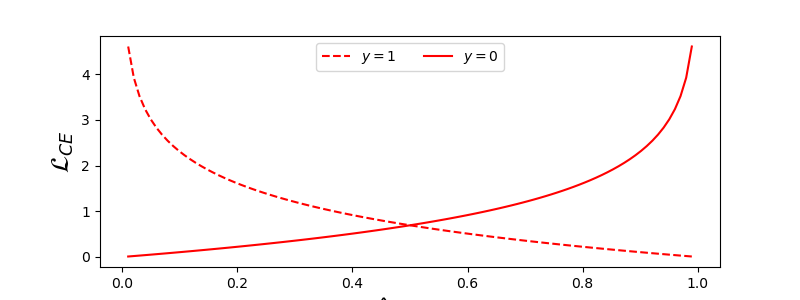

In [16]:
def cross_ent(prediction, ground_truth):
    t = 1 if ground_truth > 0.5 else 0
    return -t * np.log(prediction) - (1 - t) * np.log(1 - prediction)
plot_cross_ent()

تابع ضرر آنتروپی متقاطع به طور مجدد به عنوان یک لایه جداگانه تعریف خواهد شد، اما تابع `فوروارد` دارای دو مقدار ورودی خواهد بود: خروجی لایه های قبلی شبکه `p` و کلاس مورد انتظار `y`.

In [17]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean() # average over all input samples

cross_ent_loss = CrossEntropyLoss()
p = softmax.forward(net.forward(train_x[0:10]))
cross_ent_loss.forward(p,train_labels[0:10])

0.5336470851175024

**مهم**: تابع زیان عددی را ارائه می دهد که نشان می دهد شبکه ما چقدر خوب (یا بد) عمل می کند. این تابع باید یک عدد برای کل داده‌ها یا برای بخشی از داده‌ها (مینی-بچ) بازگرداند. بنابراین، پس از محاسبه میزان از دست رفتن کراس آنتروپی برای هر جزء فردی از بردار ورودی، لازم است که تمامی اجزا را با یکدیگر میانگین‌گیری (یا جمع) کنیم که این عملیات با فراخوانی تابع `.mean()` انجام می‌پذیرد.

## گراف محاسباتی

<img src="https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/3-NeuralNetworks/04-OwnFramework/images/ComputeGraph.png?raw=true" width="600px"/>

تا به این مرحله، ما کلاس‌های مختلفی برای لایه‌های گوناگون شبکه تعریف نموده‌ایم. ترکیب این لایه‌ها می‌تواند به صورت **گراف محاسباتی** نمایش داده شود. اکنون قادر خواهیم بود میزان ضرر را برای یک مجموعه داده آموزشی خاص (یا بخشی از آن) به روش زیر محاسبه نماییم:


In [19]:
z = net.forward(train_x[0:10])
p = softmax.forward(z)
loss = cross_ent_loss.forward(p,train_labels[0:10])
print(loss)

0.5336470851175024


## مسئله حداقل سازی ضرر و آموزش شبکه

زمانی که شبکه خود را به عنوان $f_\theta$ تعریف کردیم و تابع ضرر $\mathcal{L}(Y,f_\theta(X))$ را در نظر گرفتیم، می توانیم $\mathcal{L}$ را به عنوان تابعی از $\theta$ تحت مجموعه داده های آموزشی ثابت خود در نظر بگیریم: 

$\mathcal{L}(\theta) = \mathcal{L}(Y,f_\theta(X))$

در این صورت، آموزش شبکه به عنوان یک مسئله حداقل‌سازی از $\mathcal{L}$ با توجه به آرگومان $\theta$ خواهد بود:
$$
\theta = \mathrm{argmin}_{\theta} \mathcal{L}(Y,f_\theta(X))
$$

یک روش شناخته‌شده برای بهینه‌سازی تابع به نام **نزول گرادیان** وجود دارد. ایده این است که می‌توانیم مشتق (که در حالت چندبعدی به آن **گرادیان** می‌گویند) تابع ضرر را نسبت به پارامترها محاسبه کنیم و پارامترها را به گونه‌ای تغییر دهیم که خطا کاهش یابد.

نزول گرادیان به شرح زیر عمل می‌کند:
* پارامترها را با برخی مقادیر تصادفی $w^{(0)}$, $b^{(0)}$ مقداردهی اولیه کنید.
* مرحله زیر را چندین بار تکرار کنید:

 $$\begin{align}
 W^{(i+1)}&=W^{(i)}-\eta\frac{\partial\mathcal{L}}{\partial W}\\
 b^{(i+1)}&=b^{(i)}-\eta\frac{\partial\mathcal{L}}{\partial b}
 \end{align}
 $$


در جریان آموزش، مراحل بهینه سازی باید با توجه به کل مجموعه داده محاسبه شوند (به خاطر داشته باشید که ضرر به عنوان مجموع یا میانگین از طریق تمام نمونه های آموزشی محاسبه می شود). با این حال، در عمل، ما بخش های کوچکی از مجموعه داده به نام **مینی بچ ها** را مورد استفاده قرار می دهیم و گرادیان ها را بر اساس زیرمجموعه ای از داده ها محاسبه می کنیم. از آنجا که هر بار زیرمجموعه به صورت تصادفی انتخاب می شود، این روش **نزول گرادیان تصادفی** نامیده می شود.
 

## Backward Propagation

<img src="https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/3-NeuralNetworks/04-OwnFramework/images/ComputeGraph.png?raw=true" width="300px" align="left"/>

$$\def\L{\mathcal{L}}\def\zz#1#2{\frac{\partial#1}{\partial#2}}
\begin{align}
\zz{\L}{W} =& \zz{\L}{p}\zz{p}{z}\zz{z}{W}\cr
\zz{\L}{b} =& \zz{\L}{p}\zz{p}{z}\zz{z}{b}
\end{align}
$$


برای محاسبه $\partial\mathcal{L}/\partial W$ می‌توان از **قاعده زنجیره‌ای** برای محاسبه مشتق‌های یک تابع ترکیبی بهره برد، همان‌طور که در فرمول‌های فوق نشان داده شده است. این به ایده زیر مرتبط می‌باشد:

* فرض کنیم تحت ورودی معین، ما ضرر $\Delta\mathcal{L}$ را محاسبه کرده‌ایم.
* برای حداقل کردن این ضرر، باید خروجی سافت‌مکس $p$ را با توجه به مقدار $\Delta p = (\partial\mathcal{L}/\partial p)\Delta\mathcal{L}$ تنظیم نماییم.  
* این امر به تغییرات گره $z$ به‌صورت $\Delta z = (\partial\mathcal{p}/\partial z)\Delta p$ مرتبط می‌شود.
* به منظور حداقل کردن این خطا، نیاز است که پارامترها به طور مناسب تنظیم گردند: $\Delta W = (\partial\mathcal{z}/\partial W)\Delta z$ (and the same for $b$)


<img src="https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/3-NeuralNetworks/04-OwnFramework/images/ComputeGraphGrad.png?raw=true" width="400px" align="right"/>

این فرآیند شروع به پخش کردن خطای ضرر از خروجی شبکه به سوی پارامترهای آن می‌کند. بنابراین، این فرآیند **پس‌انتشار** نام‌گذاری شده است.

یک مرحله از آموزش شبکه شامل دو بخش اصلی است:
* **پاس جلو**، زمانی که مقدار تابع ضرر را برای یک مینی‌بچ ورودی مشخص محاسبه می‌کنیم.
* **پاس عقب**، زمانی که تلاش می‌کنیم این خطا را با توزیع آن به پارامترهای مدل از طریق گراف محاسباتی حداقل نماییم.



### Implementation of Back Propagation

* Let's add `backward` function to each of our nodes that will compute the derivative and propagate the error during the backward pass.
* We also need to implement parameter updates according to the procedure described above

We need to compute derivatives for each layer manually, for example for linear layer $z = x\times W+b$:
$$\begin{align}
\frac{\partial z}{\partial W} &= x \\
\frac{\partial z}{\partial b} &= 1 \\
\end{align}$$

If we need to compensate for the error $\Delta z$ at the output of the layer, we need to update the weights accordingly:
$$\begin{align}
\Delta x &= \Delta z \times W \\
\Delta W &= \frac{\partial z}{\partial W} \Delta z = \Delta z \times x \\
\Delta b &= \frac{\partial z}{\partial b} \Delta z = \Delta z \\
\end{align}$$

**IMPORTANT:** Calculations are done not for each training sample independently, but rather for a whole **minibatch**. Required parameter updates $\Delta W$ and $\Delta b$ are computed across the whole minibatch, and the respective vectors have dimensions: $x\in\mathbb{R}^{\mathrm{minibatch}\, \times\, \mathrm{nclass}}$

In [20]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In the same manner we can define `backward` function for the rest of our layers:

In [21]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

## Training the Model

Now we are ready to write the **training loop**, which will go through our dataset, and perform the optimization minibatch by minibatch.One complete pass through the dataset is often called **an epoch**:

In [22]:
lin = Linear(2,2)
softmax = Softmax()
cross_ent_loss = CrossEntropyLoss()

learning_rate = 0.1

pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Initial accuracy: ",acc)

batch_size=4
for i in range(0,len(train_x),batch_size):
    xb = train_x[i:i+batch_size]
    yb = train_labels[i:i+batch_size]
    
    # forward pass
    z = lin.forward(xb)
    p = softmax.forward(z)
    loss = cross_ent_loss.forward(p,yb)
    
    # backward pass
    dp = cross_ent_loss.backward(loss)
    dz = softmax.backward(dp)
    dx = lin.backward(dz)
    lin.update(learning_rate)
    
pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Final accuracy: ",acc)
    

Initial accuracy:  0.6875
Final accuracy:  0.8


Nice to see how we can increase accuracy of the model from about 50% to around 80% in one epoch.

## Network Class

Since in many cases neural network is just a composition of layers, we can build a class that will allow us to stack layers together and make forward and backward passes through them without explicitly programming that logic. We will store the list of layers inside the `Net` class, and use `add()` function to add new layers:

In [23]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

With this `Net` class our model definition and training becomes more neat:

In [24]:
net = Net()
net.add(Linear(2,2))
net.add(Softmax())
loss = CrossEntropyLoss()

def get_loss_acc(x,y,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))

def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)
 
train_epoch(net,train_x,train_labels)
        
print("Final loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
print("Test loss={}, accuracy={}: ".format(*get_loss_acc(test_x,test_labels)))

Initial loss=0.805933096363615, accuracy=0.3625: 
Final loss=0.45971254579955945, accuracy=0.8: 
Test loss=0.48318476188757487, accuracy=0.9: 


## Plotting the Training Process

It would be nice to see visually how the network is being trained! We will define a `train_and_plot` function for that. To visualize the state of the network we will use level map, i.e. we will represent different values of the network output using different colors.

> Do not worry if you do not understand some of the plotting code below - it is more important to understand the underlying neural network concepts.

In [25]:
def train_and_plot(n_epoch, net, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    fig, ax = plt.subplots(2, 1)
    ax[0].set_xlim(0, n_epoch + 1)
    ax[0].set_ylim(0,1)

    train_acc = np.empty((n_epoch, 3))
    train_acc[:] = np.NAN
    valid_acc = np.empty((n_epoch, 3))
    valid_acc[:] = np.NAN

    for epoch in range(1, n_epoch + 1):

        train_epoch(net,train_x,train_labels,loss,batch_size,lr)
        tloss, taccuracy = get_loss_acc(train_x,train_labels,loss)
        train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
        vloss, vaccuracy = get_loss_acc(test_x,test_labels,loss)
        valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]
        
        ax[0].set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)

        plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax[0])
        plot_decision_boundary(net, fig, ax[1])
        fig.canvas.draw()
        fig.canvas.flush_events()

    return train_acc, valid_acc

In [33]:
import matplotlib.cm as cm

def plot_decision_boundary(net, fig, ax):
    draw_colorbar = True
    # remove previous plot
    while ax.collections:
        ax.collections[0].remove()
        draw_colorbar = False

    # generate countour grid
    x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
    y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel().astype('float32'), yy.ravel().astype('float32')]
    n_classes = max(train_labels)+1
    while train_x.shape[1] > grid_points.shape[1]:
        # pad dimensions (plot only the first two)
        grid_points = np.c_[grid_points,
                            np.empty(len(xx.ravel())).astype('float32')]
        grid_points[:, -1].fill(train_x[:, grid_points.shape[1]-1].mean())

    # evaluate predictions
    prediction = np.array(net.forward(grid_points))
    # for two classes: prediction difference
    if (n_classes == 2):
        Z = np.array([0.5+(p[0]-p[1])/2.0 for p in prediction]).reshape(xx.shape)
    else:
        Z = np.array([p.argsort()[-1]/float(n_classes-1) for p in prediction]).reshape(xx.shape)
    
    # draw contour
    levels = np.linspace(0, 1, 40)
    cs = ax.contourf(xx, yy, Z, alpha=0.4, levels = levels)
    if draw_colorbar:
        fig.colorbar(cs, ax=ax, ticks = [0, 0.5, 1])
    c_map = [cm.jet(x) for x in np.linspace(0.0, 1.0, n_classes) ]
    colors = [c_map[l] for l in train_labels]
    ax.scatter(train_x[:, 0], train_x[:, 1], marker='o', c=colors, s=60, alpha = 0.5)

In [34]:
def plot_training_progress(x, y_data, fig, ax):
    styles = ['k--', 'g-']
    # remove previous plot
    while ax.lines:
        ax.lines[0].remove()
    # draw updated lines
    for i in range(len(y_data)):
        ax.plot(x, y_data[i], styles[i])
    ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],
              loc='upper center', ncol = 2)

<IPython.core.display.Javascript object>


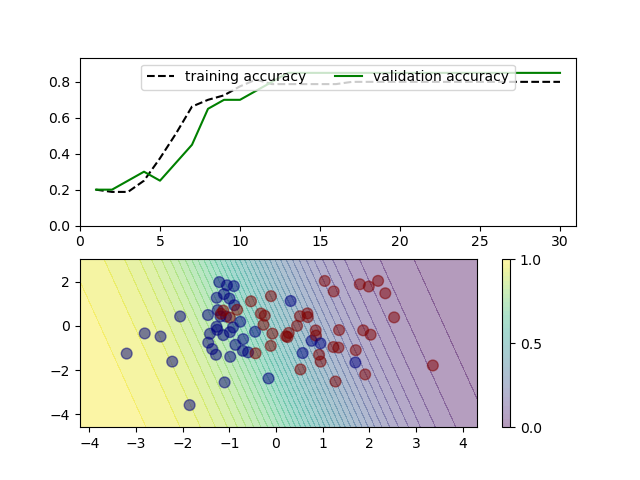

In [36]:
%matplotlib nbagg 
net = Net()
net.add(Linear(2,2))
net.add(Softmax())

res = train_and_plot(30,net,lr=0.005)

After running the cell above you should be able to see interactively how the boundary between classes change during training. Note that we have chosen very small learning rate so that we can see how the process happens.

## Multi-Layered Models

The network above has been constructed from several layers, but we still had only one `Linear` layer, which does the actual classification. What happens if we decide to add several such layers?

Surprisingly, our code will work! Very important thing to note, however, is that in between linear layers we need to have a non-linear **activation function**, such as `tanh`. Without such non-linearity, several linear layers would have the same expressive power as just one layers - because composition of linear functions is also linear!

In [37]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

 Adding several layers make sense, because unlike one-layer network, multi-layered model will be able to accuratley classify sets that are not linearly separable. I.e., a model with several layers will be **reacher**.

> It can be demonstrated that with sufficient number of neurons a two-layered model is capable to classifying any convex set of data points, and three-layered network can classify virtually any set.

Mathematically, multi-layered perceptron would be represented by a more complex function $f_\theta$ that can be computed in several steps:
* $z_1 = W_1\times x+b_1$
* $z_2 = W_2\times\alpha(z_1)+b_2$
* $f = \sigma(z_2)$

Here, $\alpha$ is a **non-linear activation function**, $\sigma$ is a softmax function, and $\theta=\langle W_1,b_1,W_2,b_2\rangle$ are parameters.

The gradient descent algorithm would remain the same, but it would be more difficult to calculate gradients. Given the
 chain differentiation rule, we can calculate derivatives as:

$$\begin{align}
\frac{\partial\mathcal{L}}{\partial W_2} &= \color{red}{\frac{\partial\mathcal{L}}{\partial\sigma}\frac{\partial\sigma}{\partial z_2}}\color{black}{\frac{\partial z_2}{\partial W_2}} \\
\frac{\partial\mathcal{L}}{\partial W_1} &= \color{red}{\frac{\partial\mathcal{L}}{\partial\sigma}\frac{\partial\sigma}{\partial z_2}}\color{black}{\frac{\partial z_2}{\partial\alpha}\frac{\partial\alpha}{\partial z_1}\frac{\partial z_1}{\partial W_1}}
\end{align}
$$

Note that the beginning of all those expressions is still the same, and thus we can continue back propagation beyond one linear layers to adjust further weights up the computational graph.

Let's now experiment with two-layered network:

In [38]:
net = Net()
net.add(Linear(2,10))
net.add(Tanh())
net.add(Linear(10,2))
net.add(Softmax())
loss = CrossEntropyLoss()

<IPython.core.display.Javascript object>


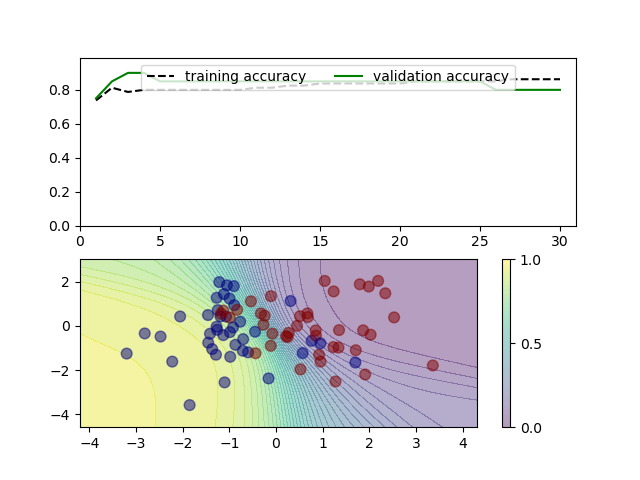

In [39]:
res = train_and_plot(30,net,lr=0.01)

## Why Not Always Use Multi-Layered Model?

We have seen that multi-layered model is more *powerful* and *expressive*, than one-layered one. You may be wondering why don't we always use many-layered model. The answer to this question is **overfitting**.

We will deal with this term more in a later sections, but the idea is the following: **the more powerful the model is, the better it can approximate training data, and the more data it needs to properly generalize** for the new data it has not seen before.

**A linear model:**
* We are likely to get high training loss - so-called **underfitting**, when the model does not have enough power to correctly separate all data. 
* Valiadation loss and training loss are more or less the same. The model is likely to generalize well to test data.

**Complex multi-layered model**
* Low training loss - the model can approximate training data well, because it has enough expressive power.
* Validation loss can be much higher than training loss and can start to increase during training - this is because the model "memorizes" training points, and loses the "overall picture"

![Overfitting](https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/3-NeuralNetworks/04-OwnFramework/images/overfit.png?raw=true)

> On this picture, `x` stands for training data, `o` - validation data. Left - linear model (one-layer), it approximates the nature of the data pretty well. Right - overfitted model, the model perfectly well approximates training data, but stops making sense with any other data (validation error is very high)

## نتایج کلیدی

* مدل‌های ساده (با لایه‌ها و نورون‌های کمتر) که دارای تعداد پارامترهای پایینی هستند ("ظرفیت پایین")، کمتر احتمال دارد تحت تأثیر بیش‌برازش قرار بگیرند.
* مدل‌های پیچیده‌تر (با لایه‌های بیشتر و نورون‌های افزون‌تر در هر لایه و ظرفیت بالا) به‌طرز بیشتری در معرض خطر بیش‌برازش قرار دارند. لازم است که خطای اعتبارسنجی را به دقت زیر نظر داشته باشیم تا از افزایش آن با ادامه آموزش اطمینان حاصل کنیم.
* این مدل‌های پیچیده‌تر به داده‌های بیشتری برای آموزش نیازمندند.
* شما می‌توانید مشکل بیش‌برازش را به یکی از روش‌های زیر حل کنید:
    - ساده‌سازی مدل خود
    - افزایش حجم داده‌های آموزشی
* **معامله بایاس-واریانس** مفهومی است که بر عدم تعادل میان
    - قدرت مدل و مقدار داده‌ها،
    - و همچنین میان بیش‌برازش و کم‌برازش تأکید دارد.
* هیچ دستورالعمل خاصی در مورد تعداد لایه‌ها و پارامترهای مورد نیاز وجود ندارد؛ بهترین روش آزمون و خطاست.

## Credits

This notebook is a part of [AI for Beginners Curricula](http://github.com/microsoft/ai-for-beginners), and has been prepared by [Dmitry Soshnikov](http://soshnikov.com). It is inspired by Neural Network Workshop at Microsoft Research Cambridge. Some code and illustrative materials are taken from presentations by [Katja Hoffmann](https://www.microsoft.com/en-us/research/people/kahofman/), [Matthew Johnson](https://www.microsoft.com/en-us/research/people/matjoh/) and [Ryoto Tomioka](https://www.microsoft.com/en-us/research/people/ryoto/), and from [NeuroWorkshop](http://github.com/shwars/NeuroWorkshop) repository.